## Introduction to CNN with MNIST


![](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/08_Convolutional_Neural_Networks/images/02_cnn1_loss_acc.png?raw=true)

![Sample Test Batch](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/08_Convolutional_Neural_Networks/images/02_cnn1_mnist_output.png?raw=true)

A random set of 6 digits with actuals and predicted labels. You can see a prediction failure in the lower right box.


In [3]:
# Introductory CNN Model: MNIST Digits
# ---------------------------------------
#
# In this example, we will download the MNIST handwritten
# digits and create a simple CNN network to predict the
# digit category (0-9)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

ops.reset_default_graph()

# Start a graph session
sess = tf.Session()
# Load data
data_dir = 'mnist'
mnist = read_data_sets(data_dir)
print(mnist.train)

Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz


In [15]:
# Convert images into 28x28 (they are downloaded as 1x784)
train_xdata = np.array([np.reshape(x,(28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x,(28,28)) for x in mnist.test.images])
print(len(train_xdata),len(test_xdata))
# print(train_xdata,test_xdata)
# Convert labels into one-hot encoded vectors
train_lables = mnist.train.labels
test_lables = mnist.test.labels
print(len(train_lables),len(test_lables))
print(train_lables,test_lables)

# Set model parameters
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
print(image_width,image_height)
target_size = max(train_lables) + 1
print(target_size)
num_channels = 1  # greyscale = 1 channel
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2  # NxN window for 1st max pool layer
max_pool_size2 = 2  # NxN window for 2nd max pool layer
fully_connected_size1 = 100

# Declare model placeholders
x_input_shape = (batch_size,image_width,image_height,num_channels)
x_input = tf.placeholder(dtype=tf.float32,shape=x_input_shape)
y_target = tf.placeholder(dtype=tf.int32,shape=(batch_size))

eval_input_shape = (evaluation_size,image_width,image_height,num_channels)
eval_input = tf.placeholder(dtype=tf.float32,shape=eval_input_shape)
eval_target = tf.placeholder(dtype=tf.int32,shape=(evaluation_size))

# Declare model parameters
conv1_weight = tf.Variable(tf.truncated_normal([4,4,num_channels,conv1_features],stddev=0.1,dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features],dtype=tf.float32))
conv2_weight = tf.Variable(tf.truncated_normal([4,4,conv1_features,conv2_features],stddev=0.1,dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features],dtype=tf.float32))

# fully connected variables
resulting_width = image_width // (max_pool_size1 * max_pool_size2) #整数除法
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size,fully_connected_size1],stddev=0.1,dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1],stddev=0.1,dtype=tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1,target_size],stddev=0.1,dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size],stddev=0.1,dtype=tf.float32))


55000 10000
55000 10000
[7 3 4 ..., 5 6 8] [7 2 1 ..., 4 5 6]
28 28
10


In [20]:
# Initialize Model Operations
def my_conv_net(input_data):
   # First Conv-ReLU-MaxPool Layer
    print(input_data,conv1_weight)
    conv1 = tf.nn.conv2d(input_data,filter=conv1_weight,strides=[1,1,1,1],padding="SAME")
    print(conv1)
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1,conv1_bias))
    print(relu1)
    max_pool1 = tf.nn.max_pool(relu1,ksize=[1,max_pool_size1,max_pool_size1,1],
                               strides=[1,max_pool_size1,max_pool_size1,1],padding="SAME")
    print(max_pool1,conv2_weight)
    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1,conv2_weight,strides=[1,1,1,1],padding="SAME")
    print(conv2)
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_bias))
    print(relu2)
    max_pool2 = tf.nn.max_pool(relu2,ksize=[1,max_pool_size2,max_pool_size2,1],
                               strides=[1,max_pool_size2,max_pool_size2,1],padding="SAME")
    print(max_pool2)
    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    print(final_conv_shape)
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2,[final_conv_shape[0],final_shape])
    # First Fully Connected Layer
    fully_connect1 = tf.nn.relu(tf.add(tf.matmul(flat_output,full1_weight),full1_bias))
    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connect1,full2_weight),full2_bias)
    print(final_model_output)
    return (final_model_output)

model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)
    

Tensor("Placeholder_4:0", shape=(100, 28, 28, 1), dtype=float32) <tf.Variable 'Variable_4:0' shape=(4, 4, 1, 25) dtype=float32_ref>
Tensor("Conv2D_16:0", shape=(100, 25, 25, 25), dtype=float32)
Tensor("Relu_24:0", shape=(100, 25, 25, 25), dtype=float32)
Tensor("MaxPool_16:0", shape=(100, 13, 13, 25), dtype=float32) <tf.Variable 'Variable_6:0' shape=(4, 4, 25, 50) dtype=float32_ref>
Tensor("Conv2D_17:0", shape=(100, 13, 13, 50), dtype=float32)
Tensor("Relu_25:0", shape=(100, 13, 13, 50), dtype=float32)
Tensor("MaxPool_17:0", shape=(100, 7, 7, 50), dtype=float32)
[100, 7, 7, 50]
Tensor("Add_17:0", shape=(100, 10), dtype=float32)
Tensor("Placeholder_6:0", shape=(500, 28, 28, 1), dtype=float32) <tf.Variable 'Variable_4:0' shape=(4, 4, 1, 25) dtype=float32_ref>
Tensor("Conv2D_18:0", shape=(500, 25, 25, 25), dtype=float32)
Tensor("Relu_27:0", shape=(500, 25, 25, 25), dtype=float32)
Tensor("MaxPool_18:0", shape=(500, 13, 13, 25), dtype=float32) <tf.Variable 'Variable_6:0' shape=(4, 4, 25, 50)

In [26]:
# Declare Loss Function (softmax cross entropy)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output,labels=y_target))
# Create a prediction function
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)
# create accuracy function
def get_accuracy(logits,targets):
    batch_predictions = np.argmax(logits,axis=1)
    num_correct = np.sum(np.equal(batch_predictions,targets))
    return (100. * num_correct / batch_predictions.shape[0])
# Create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

In [29]:
# Start training loop
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_xdata),size=batch_size)
    rand_x = train_xdata[rand_index]
    rand_x = np.expand_dims(rand_x,3)
    rand_y = train_lables[rand_index]
    train_dict = {x_input: rand_x,y_target: rand_y}
    sess.run(train_step,feed_dict=train_dict)
    temp_train_loss,temp_train_predict = sess.run([loss,prediction],feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_predict,rand_y)
    if (i + 1) % eval_every == 0:
        eval_index = np.random.choice(len(test_xdata),size=evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x,3)
        eval_y = test_lables[eval_index]
        test_dict = {eval_input:eval_x,eval_target:eval_y}
        test_predict = sess.run(test_prediction,feed_dict=test_dict)
        tmp_test_acc = get_accuracy(test_predict,eval_y)
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(tmp_test_acc)
        acc_and_loss = [(i + 1), temp_train_loss, temp_train_acc, tmp_test_acc]
        acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
print(eval_indices)

Generation # 5. Train Loss: 2.19. Train Acc (Test Acc): 33.00 (34.00)
Generation # 10. Train Loss: 2.14. Train Acc (Test Acc): 38.00 (32.00)
Generation # 15. Train Loss: 2.08. Train Acc (Test Acc): 35.00 (34.60)
Generation # 20. Train Loss: 1.88. Train Acc (Test Acc): 57.00 (50.00)
Generation # 25. Train Loss: 1.74. Train Acc (Test Acc): 62.00 (57.80)
Generation # 30. Train Loss: 1.52. Train Acc (Test Acc): 63.00 (62.80)
Generation # 35. Train Loss: 1.33. Train Acc (Test Acc): 68.00 (69.20)
Generation # 40. Train Loss: 0.96. Train Acc (Test Acc): 77.00 (75.80)
Generation # 45. Train Loss: 0.55. Train Acc (Test Acc): 89.00 (73.40)
Generation # 50. Train Loss: 0.74. Train Acc (Test Acc): 78.00 (81.00)
Generation # 55. Train Loss: 0.54. Train Acc (Test Acc): 84.00 (81.20)
Generation # 60. Train Loss: 0.68. Train Acc (Test Acc): 79.00 (83.60)
Generation # 65. Train Loss: 0.58. Train Acc (Test Acc): 82.00 (82.80)
Generation # 70. Train Loss: 0.36. Train Acc (Test Acc): 91.00 (86.40)
Generat

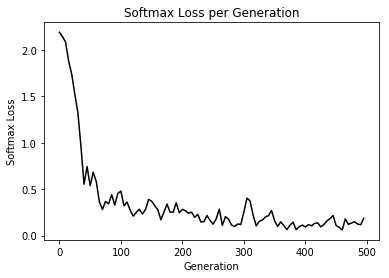

In [30]:
# Matlotlib code to plot the loss and accuracies
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

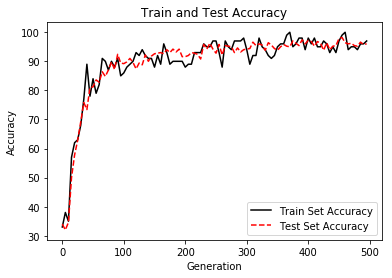

In [31]:
# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

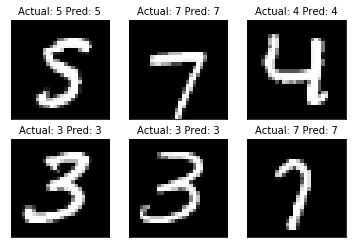

In [35]:
# Plot some samples
# Plot the 6 of the last batch results:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_predict, axis=1)[0:6]
images = np.squeeze(rand_x[0:6])

Nrows = 2
Ncols = 3
for i in range(6):
    plt.subplot(Nrows, Ncols, i + 1)
    plt.imshow(np.reshape(images[i], [28, 28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]),
              fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)